# **Test Pre-trained ResNet152**

## **Import Libraries**

In [1]:
from google.colab import drive
import os
import shutil
import time
from tqdm import tqdm
import glob
import gc

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import random as rn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet152
from keras.models import Model

## **Unzip Dataset from Google Drive**

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/DATASET.zip -d /content

## **Set Environmental Parameters**

In [3]:
seed = 42
# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"]="0"
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(seed)
# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tf.random.set_seed(seed)

In [4]:
BASE_PATH = '/content/drive/MyDrive/CIDL_Group'
MODELS_PATH = os.path.join(BASE_PATH, 'PRE-TRAINED_MODELS', 'ResNet152')
LOCAL_MODELS_PATH = os.path.join(BASE_PATH, 'tmp_models')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

AUTOTUNE = tf.data.AUTOTUNE
INTERPOLATION = "bilinear"


LOSS_FUNC = 'sparse_categorical_crossentropy'

METRICS = ['accuracy']

In [ ]:
DATASET_PATH = '/content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')
CLASSES = os.listdir(TRAIN_PATH)

## **Check Class Distribution**

In [ ]:
def get_class_distribution(dataset, to_print=False):
  
  len([name for name in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, name))])

  distribution = []
  total = 0
  for dir in tqdm(os.listdir(dataset)):
    sub_dir = dataset + "/" + dir + "/*"
    number = len(glob.glob(sub_dir))
    distribution.append(number)
    total += number
    
  if print:
    for i in range(len(CLASSES)):
      print(f'Number of {CLASSES[i]}: {distribution[i]}, proportion: {distribution[i]/(total)}')
  
  return distribution, total


def plot_class_distribution(dataset, name):
  distribution, _ = get_class_distribution(dataset, to_print=True)

  plt.figure(figsize=(10, 6), dpi=80)
  plt.bar(CLASSES, height=distribution)
  plt.title(f'Barplot of class distribution of {name} dataset')
  plt.show()

100%|██████████| 4/4 [00:00<00:00, 148.67it/s]

Number of Infiltration: 2430, proportion: 0.3376876042245692
Number of Atelectasis: 1211, proportion: 0.16828793774319067
Number of No Finding: 2430, proportion: 0.3376876042245692
Number of Effusion: 1125, proportion: 0.15633685380767093


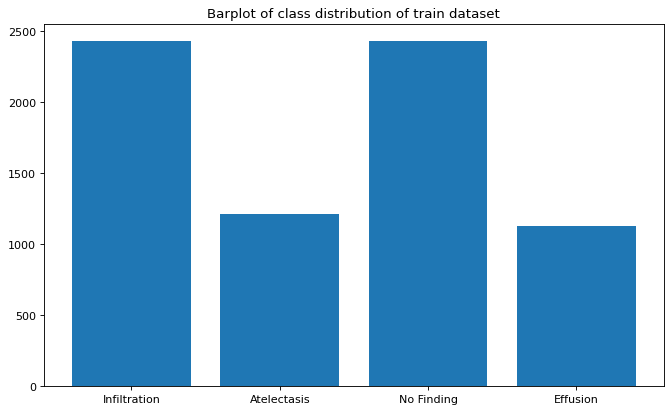

100%|██████████| 4/4 [00:00<00:00, 716.79it/s]


Number of Infiltration: 270, proportion: 0.3375
Number of Atelectasis: 135, proportion: 0.16875
Number of No Finding: 270, proportion: 0.3375
Number of Effusion: 125, proportion: 0.15625


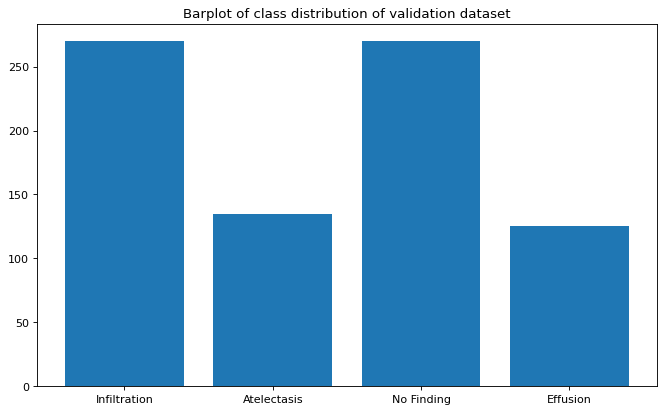

100%|██████████| 4/4 [00:00<00:00, 265.45it/s]


Number of Infiltration: 300, proportion: 0.3374578177727784
Number of Atelectasis: 150, proportion: 0.1687289088863892
Number of No Finding: 300, proportion: 0.3374578177727784
Number of Effusion: 139, proportion: 0.156355455568054


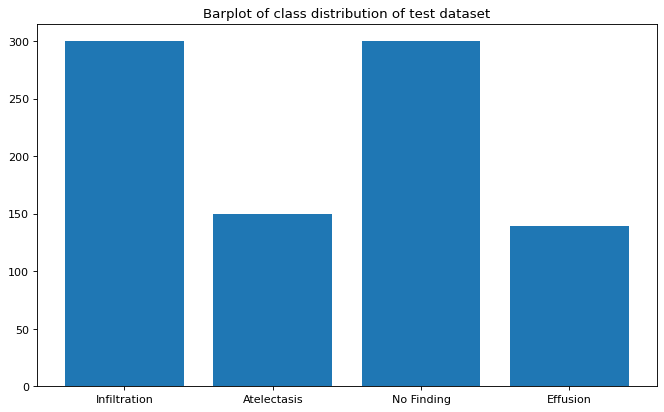

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

## **Utility Functions**

In [5]:
def extract_labels(ds):
  ds_labels = []
  for images, labels in ds.unbatch():
    ds_labels.append(labels.numpy())
  return np.array(ds_labels)


def show_training_and_validation_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def load_training_set (image_size, batch_size, shuffle=True):
  train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  train_ds = train_ds.cache()
  if shuffle:
    train_ds = train_ds.shuffle(BATCH_SIZE * 100)
  train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
  return train_ds


def load_validation_set (image_size, batch_size):
  val_ds = image_dataset_from_directory(
    VAL_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return val_ds


def load_test_set (image_size, batch_size):
  test_ds = image_dataset_from_directory(
    TEST_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return test_ds


def compile_model (model, optimizer='adam', learning_rate = 0.001):
  if optimizer == 'adam':
    model.compile(loss=LOSS_FUNC,
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=METRICS)
  elif optimizer == 'rmsprop':
    model.compile(loss=LOSS_FUNC,
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=METRICS)
  model.summary()


def run_model (model, model_name, train_set, val_set, epochs = 20, patience=5, min_lr = 1e-8, c_weight=False, monitor='val_loss'):
  # local save path for the models
  save_path = os.path.join(LOCAL_MODELS_PATH, f'{model_name}.h5')

  callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor = monitor, 
                      patience = patience),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor = monitor, 
                      factor = 0.8,
                      patience = (patience*6/10), 
                      min_lr = min_lr,
                      min_delta=0.001,
                      verbose = 1),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor = monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  
  if not c_weight:
    class_weights = None
  else:
    train_labels = extract_labels(train_set)
    class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                      classes=np.unique(train_labels), 
                                                      y=train_labels)
    class_weights = dict(enumerate(class_weights))

  history = model.fit(train_set,
                      epochs = epochs,
                      validation_data = val_set,
                      callbacks = callbacks_list, 
                      class_weight=class_weights)
  
  # save on Drive only the best model
  best_model_path = os.path.join(MODELS_PATH, f'{model_name}.h5')
  if os.path.exists(best_model_path):
    os.remove(best_model_path)
  shutil.copy(save_path, best_model_path)
  
  return history


def evaluate_model (model, test_set):
  test_loss, test_acc = model.evaluate(test_set)
  print(f'Test accuracy: {test_acc:.3f}\nTest loss: {test_loss:.3f}')

def display_confusion_matrix(model, test_set):
  y_pred = model.predict(test_set)
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.concat([y for x, y in test_set], axis=0)
  print("Classification report: ")
  print(metrics.classification_report(y_true, y_pred, digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

## **Load Train, Validation and Test**

In [ ]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
train_set_no_shuffle = load_training_set(IMAGE_SIZE, BATCH_SIZE, shuffle=False)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

NameError: ignored

## **Leverage ResNet152 as Feature Extractor**

In [ ]:
conv_base = keras.applications.resnet.ResNet152(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,)
)
conv_base.summary()
conv_base.trainable = False

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2)
])

### **Extract features for reuse**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
outputs = conv_base(x)
model = keras.Model(inputs, outputs)

In [ ]:
train_features = model.predict(train_set_no_shuffle)

FEATURE_SHAPE = train_features.shape[1:]

In [ ]:
train_labels = extract_labels(train_set_no_shuffle)

In [ ]:
# Create Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 100)

In [ ]:
del train_features
del train_labels
gc.collect()

In [ ]:
val_features = model.predict(val_set)

In [ ]:
val_labels = extract_labels(val_set)

In [ ]:
# Create Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(BATCH_SIZE)

In [ ]:
del val_features
del val_labels
gc.collect()

In [ ]:
test_features = model.predict(test_set)

In [ ]:
test_labels = extract_labels(test_set)

In [ ]:
# Create Dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(BATCH_SIZE)

In [ ]:
del test_features
del test_labels
gc.collect()

In [ ]:
del model
K.clear_session()
gc.collect()

### **Experiment 1] Dense Layer**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               2569

In [ ]:
history = run_model(model, 'ResNet152_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 6.1221 - accuracy: 0.4454
Epoch 00001: val_loss improved from inf to 1.50104, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 145s 570ms/step - loss: 6.1221 - accuracy: 0.4454 - val_loss: 1.5010 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6964
Epoch 00002: val_loss improved from 1.50104 to 1.17785, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp1.h5
225/225 [==============================] - 127s 565ms/step - loss: 0.8152 - accuracy: 0.6964 - val_loss: 1.1778 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.8138
Epoch 00003: val_loss did not improve from 1.17785
225/225 [==============================] - 121s 536ms/step - loss: 0.4714 - accuracy: 0.8138 - val_loss: 1.3628 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8915
Epoch 00004: val_loss did not improve from 1.17785
225/225 [======================

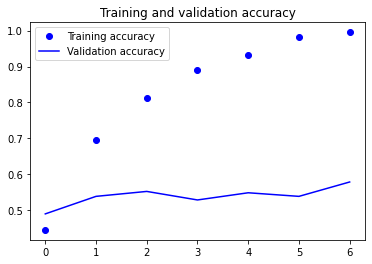

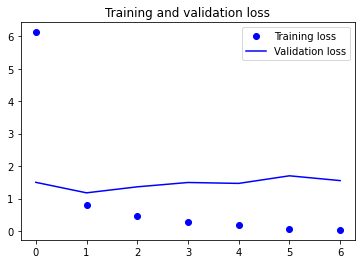

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp1.h5'))

28/28 [==============================] - 17s 476ms/step - loss: 1.1607 - accuracy: 0.5321
Test accuracy: 0.532
Test loss: 1.161
Classification report: 
              precision    recall  f1-score   support

           0     0.3295    0.3867    0.3558       150
           1     0.3661    0.6691    0.4733       139
           2     0.6240    0.5200    0.5673       300
           3     0.7943    0.5533    0.6523       300

    accuracy                         0.5321       889
   macro avg     0.5285    0.5323    0.5122       889
weighted avg     0.5915    0.5321    0.5456       889



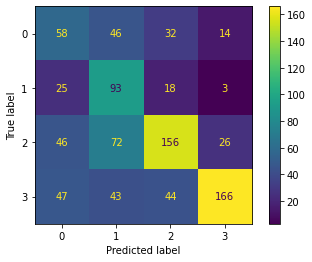

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

4742

### **Experiment 2] Dense Layer + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                             

In [ ]:
history = run_model(model, 'ResNet152_exp2', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 4.6755 - accuracy: 0.2204
Epoch 00001: val_loss improved from inf to 1.33501, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 96s 350ms/step - loss: 4.6755 - accuracy: 0.2204 - val_loss: 1.3350 - val_accuracy: 0.2587 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.2474
Epoch 00002: val_loss improved from 1.33501 to 1.27792, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp2.h5
225/225 [==============================] - 59s 263ms/step - loss: 1.3563 - accuracy: 0.2474 - val_loss: 1.2779 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.3242 - accuracy: 0.2800
Epoch 00003: val_loss improved from 1.27792 to 1.24368, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp2.h5
225/225 [==============================] - 60s 265ms/step - loss: 1.3242 - accuracy: 0.2800 - val_loss: 1.2437 - val_accuracy: 0.3862 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.2800 - accuracy: 0.2903
E

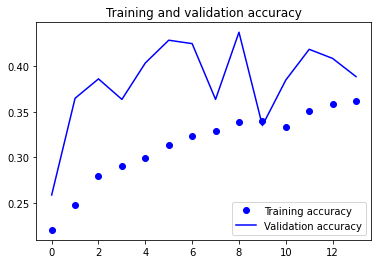

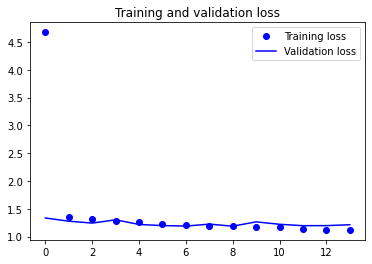

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp2.h5'))

28/28 [==============================] - 16s 371ms/step - loss: 1.1856 - accuracy: 0.4218
Test accuracy: 0.422
Test loss: 1.186
Classification report: 
              precision    recall  f1-score   support

           0     0.2336    0.6400    0.3422       150
           1     0.4828    0.4029    0.4392       139
           2     0.4086    0.1267    0.1934       300
           3     0.6877    0.6167    0.6503       300

    accuracy                         0.4218       889
   macro avg     0.4532    0.4466    0.4063       889
weighted avg     0.4849    0.4218    0.4111       889



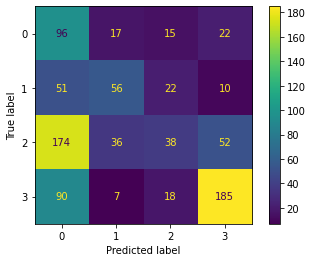

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 3] 2 Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                             

In [ ]:
history = run_model(model, 'ResNet152_exp3', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

None
Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 3.5799 - accuracy: 0.3362
Epoch 00001: val_loss improved from inf to 1.32541, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp3.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 77s 298ms/step - loss: 3.5799 - accuracy: 0.3362 - val_loss: 1.3254 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.3705 - accuracy: 0.3373
Epoch 00002: val_loss did not improve from 1.32541
225/225 [==============================] - 60s 268ms/step - loss: 1.3705 - accuracy: 0.3373 - val_loss: 1.3522 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.3506 - accuracy: 0.3357
Epoch 00003: val_loss did not improve from 1.32541
225/225 [==============================] - 59s 264ms/step - loss: 1.3506 - accuracy: 0.3357 - val_loss: 1.3786 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.3371
Epoch 00004: val_loss improved from 1.32541 to 1.31903, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp3.h5
225/225 [=========================

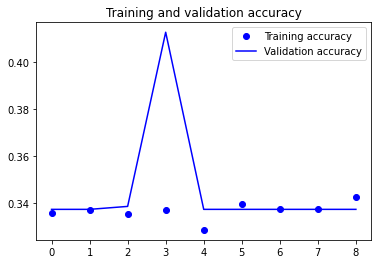

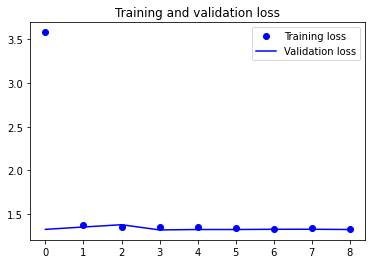

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp3.h5'))

28/28 [==============================] - 10s 227ms/step - loss: 1.3182 - accuracy: 0.3870
Test accuracy: 0.387
Test loss: 1.318
Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       150
           1     0.0000    0.0000    0.0000       139
           2     0.3457    0.8100    0.4845       300
           3     0.5430    0.3367    0.4156       300

    accuracy                         0.3870       889
   macro avg     0.2222    0.2867    0.2250       889
weighted avg     0.2999    0.3870    0.3038       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


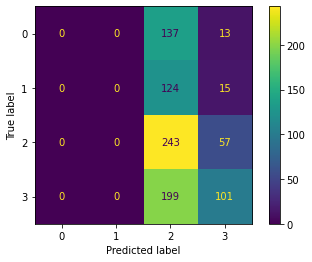

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 4] Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544

In [ ]:
history = run_model(model, 'ResNet152_exp4', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.3799 - accuracy: 0.4041
Epoch 00001: val_loss improved from inf to 1.22908, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp4.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 142s 559ms/step - loss: 1.3799 - accuracy: 0.4041 - val_loss: 1.2291 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.2121 - accuracy: 0.4594
Epoch 00002: val_loss improved from 1.22908 to 1.15374, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp4.h5
225/225 [==============================] - 123s 547ms/step - loss: 1.2121 - accuracy: 0.4594 - val_loss: 1.1537 - val_accuracy: 0.4663 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.1947 - accuracy: 0.4668
Epoch 00003: val_loss did not improve from 1.15374
225/225 [==============================] - 119s 530ms/step - loss: 1.1947 - accuracy: 0.4668 - val_loss: 1.1579 - val_accuracy: 0.5075 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.4922
Epoch 00004: val_loss improved from 1.15374 to 1.13055, saving model to /content/d

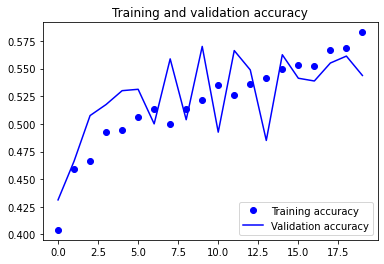

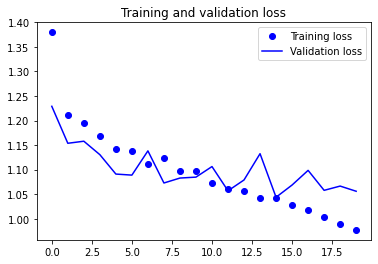

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp4.h5'))

28/28 [==============================] - 21s 490ms/step - loss: 1.0326 - accuracy: 0.5714
Test accuracy: 0.571
Test loss: 1.033
Classification report: 
              precision    recall  f1-score   support

           0     0.3602    0.4467    0.3988       150
           1     0.4850    0.5827    0.5294       139
           2     0.6611    0.5267    0.5863       300
           3     0.6801    0.6733    0.6767       300

    accuracy                         0.5714       889
   macro avg     0.5466    0.5574    0.5478       889
weighted avg     0.5892    0.5714    0.5763       889



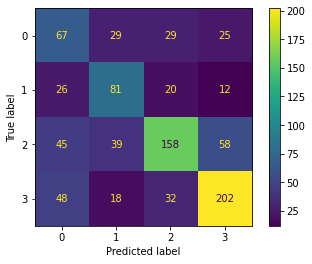

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

84906

### **Experiment 5] AVG Pooling + Flatten + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = conv_base(x)
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 2048)       0         
 ooling2D)                                                   

In [ ]:
history = run_model(model, 'ResNet152_exp5', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.4052 - accuracy: 0.3758
Epoch 00001: val_loss improved from inf to 1.23696, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp5.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 74s 280ms/step - loss: 1.4052 - accuracy: 0.3758 - val_loss: 1.2370 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.4262
Epoch 00002: val_loss did not improve from 1.23696
225/225 [==============================] - 60s 266ms/step - loss: 1.2585 - accuracy: 0.4262 - val_loss: 1.2531 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.2257 - accuracy: 0.4514
Epoch 00003: val_loss improved from 1.23696 to 1.22237, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp5.h5
225/225 [==============================] - 63s 282ms/step - loss: 1.2257 - accuracy: 0.4514 - val_loss: 1.2224 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.2221 - accuracy: 0.4557
Epoch 00004: val_loss did not improve from 1.22237
225/225 [=========================

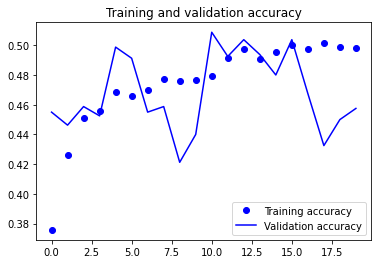

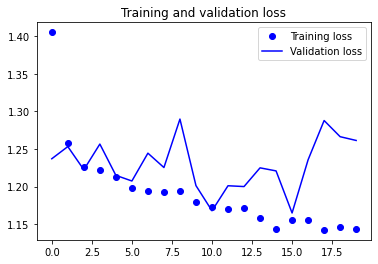

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp5.h5'))

28/28 [==============================] - 9s 214ms/step - loss: 1.1554 - accuracy: 0.5219
Test accuracy: 0.522
Test loss: 1.155
Classification report: 
              precision    recall  f1-score   support

           0     0.3143    0.5133    0.3899       150
           1     0.4332    0.5827    0.4969       139
           2     0.6000    0.5600    0.5793       300
           3     0.7797    0.4600    0.5786       300

    accuracy                         0.5219       889
   macro avg     0.5318    0.5290    0.5112       889
weighted avg     0.5863    0.5219    0.5342       889



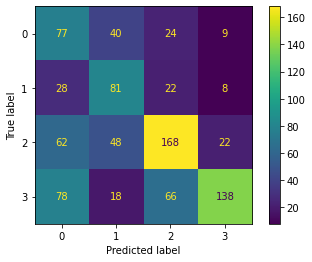

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 6] Global AVG Pooling + Dense + Batch Normalization + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
history = run_model(model, 'ResNet152_exp6', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.3960 - accuracy: 0.4471
Epoch 00001: val_loss improved from inf to 1.35780, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp6.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 112s 283ms/step - loss: 1.3960 - accuracy: 0.4471 - val_loss: 1.3578 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1132 - accuracy: 0.5354
Epoch 00002: val_loss improved from 1.35780 to 1.07144, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp6.h5
225/225 [==============================] - 62s 278ms/step - loss: 1.1132 - accuracy: 0.5354 - val_loss: 1.0714 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.5737
Epoch 00003: val_loss improved from 1.07144 to 1.03075, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp6.h5
225/225 [==============================] - 62s 276ms/step - loss: 1.0109 - accuracy: 0.5737 - val_loss: 1.0308 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.6044


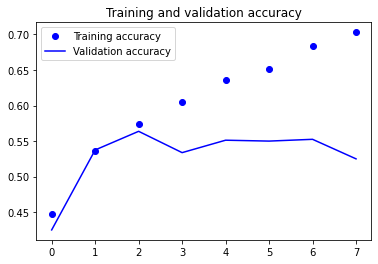

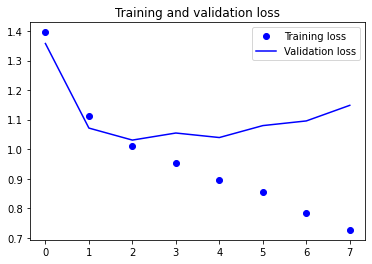

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp6.h5'))

28/28 [==============================] - 12s 238ms/step - loss: 1.0004 - accuracy: 0.5838
Test accuracy: 0.584
Test loss: 1.000
Classification report: 
              precision    recall  f1-score   support

           0     0.3926    0.3533    0.3719       150
           1     0.5096    0.5755    0.5405       139
           2     0.5941    0.6000    0.5970       300
           3     0.7007    0.6867    0.6936       300

    accuracy                         0.5838       889
   macro avg     0.5492    0.5539    0.5508       889
weighted avg     0.5828    0.5838    0.5828       889



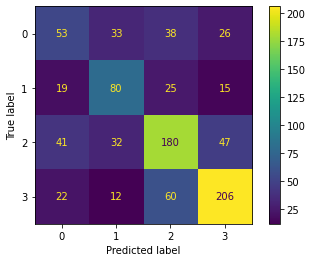

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 7] Global AVG Pooling + Dense + Regularization + Batch Normalization + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, kernel_regularizer='l2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax', kernel_regularizer='l2')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
history = run_model(model, 'ResNet152_exp7', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 3.5994 - accuracy: 0.4432
Epoch 00001: val_loss improved from inf to 2.08241, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp7.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 144s 555ms/step - loss: 3.5994 - accuracy: 0.4432 - val_loss: 2.0824 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.8457 - accuracy: 0.5113
Epoch 00002: val_loss improved from 2.08241 to 1.65930, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp7.h5
225/225 [==============================] - 123s 548ms/step - loss: 1.8457 - accuracy: 0.5113 - val_loss: 1.6593 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.5211 - accuracy: 0.5158
Epoch 00003: val_loss improved from 1.65930 to 1.48737, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp7.h5
225/225 [==============================] - 123s 547ms/step - loss: 1.5211 - accuracy: 0.5158 - val_loss: 1.4874 - val_accuracy: 0.4925 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.4005 - accuracy: 0.531

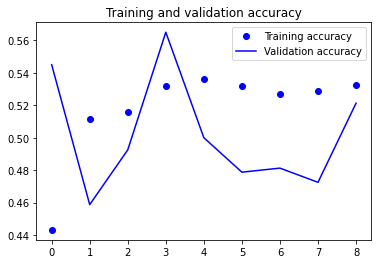

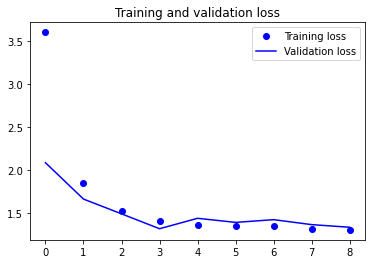

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp7.h5'))

28/28 [==============================] - 17s 474ms/step - loss: 1.2921 - accuracy: 0.5816
Test accuracy: 0.582
Test loss: 1.292
Classification report: 
              precision    recall  f1-score   support

           0     0.4217    0.2333    0.3004       150
           1     0.4710    0.5252    0.4966       139
           2     0.5674    0.6733    0.6159       300
           3     0.7017    0.6900    0.6958       300

    accuracy                         0.5816       889
   macro avg     0.5404    0.5305    0.5272       889
weighted avg     0.5731    0.5816    0.5710       889



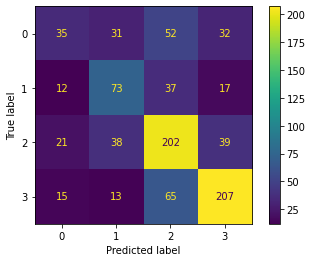

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

38608

### **Experiment 8] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'ResNet152_exp8', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.3595 - accuracy: 0.3815
Epoch 00001: val_loss improved from inf to 1.27006, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp8.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 156s 621ms/step - loss: 1.3595 - accuracy: 0.3815 - val_loss: 1.2701 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.2583 - accuracy: 0.4286
Epoch 00002: val_loss improved from 1.27006 to 1.21266, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp8.h5
225/225 [==============================] - 136s 605ms/step - loss: 1.2583 - accuracy: 0.4286 - val_loss: 1.2127 - val_accuracy: 0.4487 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.4439
Epoch 00003: val_loss improved from 1.21266 to 1.16797, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp8.h5
225/225 [==============================] - 136s 606ms/step - loss: 1.2380 - accuracy: 0.4439 - val_loss: 1.1680 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.446

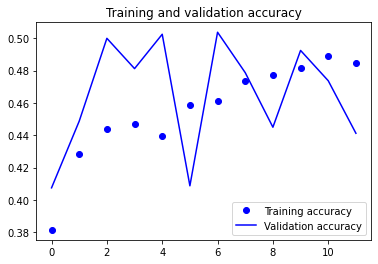

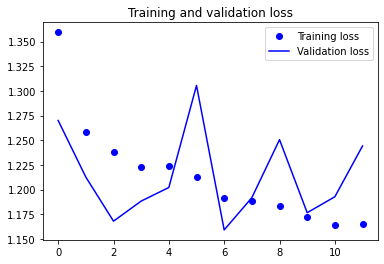

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp8.h5'))

28/28 [==============================] - 17s 474ms/step - loss: 1.1476 - accuracy: 0.5343
Test accuracy: 0.534
Test loss: 1.148
Classification report: 
              precision    recall  f1-score   support

           0     0.3066    0.4333    0.3591       150
           1     0.4178    0.6403    0.5057       139
           2     0.6378    0.5400    0.5848       300
           3     0.7571    0.5300    0.6235       300

    accuracy                         0.5343       889
   macro avg     0.5298    0.5359    0.5183       889
weighted avg     0.5878    0.5343    0.5474       889



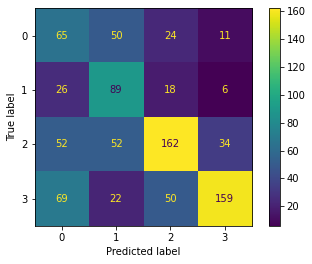

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

95149

### **Experiment 9] Global AVG Pooling + Dense 64**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_exp9', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2546 - accuracy: 0.4483
Epoch 00001: val_loss improved from inf to 1.11579, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp9.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 152s 581ms/step - loss: 1.2546 - accuracy: 0.4483 - val_loss: 1.1158 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1189 - accuracy: 0.5215
Epoch 00002: val_loss improved from 1.11579 to 1.10984, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp9.h5
225/225 [==============================] - 123s 547ms/step - loss: 1.1189 - accuracy: 0.5215 - val_loss: 1.1098 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.0691 - accuracy: 0.5506
Epoch 00003: val_loss did not improve from 1.10984
225/225 [==============================] - 119s 528ms/step - loss: 1.0691 - accuracy: 0.5506 - val_loss: 1.1172 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.5574
Epoch 00004: val_loss improved from 1.10984 to 1.08012, saving model to /content/d

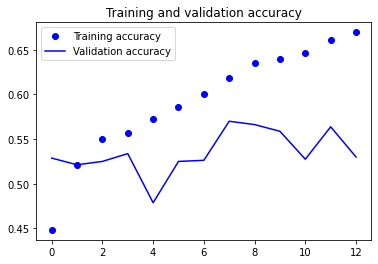

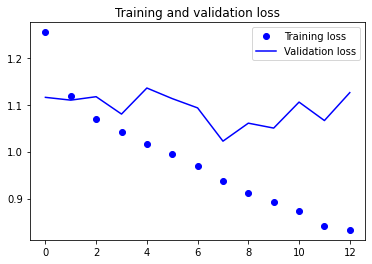

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp9.h5'))

28/28 [==============================] - 29s 608ms/step - loss: 0.9937 - accuracy: 0.5793
Test accuracy: 0.579
Test loss: 0.994
Classification report: 
              precision    recall  f1-score   support

           0     0.3862    0.3733    0.3797       150
           1     0.4833    0.6259    0.5455       139
           2     0.6653    0.5433    0.5982       300
           3     0.6552    0.6967    0.6753       300

    accuracy                         0.5793       889
   macro avg     0.5475    0.5598    0.5496       889
weighted avg     0.5863    0.5793    0.5791       889



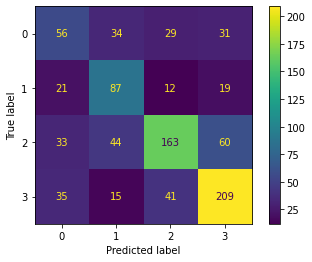

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 10] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_exp10', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2925 - accuracy: 0.4202
Epoch 00001: val_loss improved from inf to 1.14756, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp10.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 162s 631ms/step - loss: 1.2925 - accuracy: 0.4202 - val_loss: 1.1476 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1730 - accuracy: 0.4832
Epoch 00002: val_loss improved from 1.14756 to 1.13075, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp10.h5
225/225 [==============================] - 137s 608ms/step - loss: 1.1730 - accuracy: 0.4832 - val_loss: 1.1307 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.5050
Epoch 00003: val_loss improved from 1.13075 to 1.10311, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_exp10.h5
225/225 [==============================] - 134s 595ms/step - loss: 1.1385 - accuracy: 0.5050 - val_loss: 1.1031 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.1164 - accuracy: 0.5

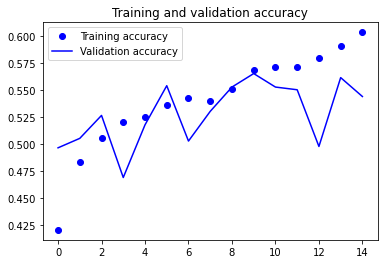

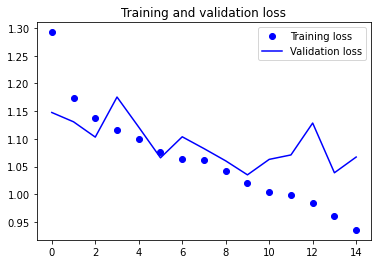

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_exp10.h5'))

28/28 [==============================] - 30s 610ms/step - loss: 1.0297 - accuracy: 0.5714
Test accuracy: 0.571
Test loss: 1.030
Classification report: 
              precision    recall  f1-score   support

           0     0.3725    0.3800    0.3762       150
           1     0.4576    0.5827    0.5127       139
           2     0.6569    0.5233    0.5826       300
           3     0.6656    0.7100    0.6871       300

    accuracy                         0.5714       889
   macro avg     0.5382    0.5490    0.5396       889
weighted avg     0.5807    0.5714    0.5721       889



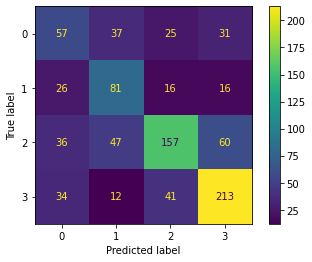

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

### **Experiment 11] Global AVG Pooling + Dense 128 + Dropout 0.33**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.33)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
history = run_model(model, 'ResNet152_ex11', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2944 - accuracy: 0.4191
Epoch 00001: val_loss improved from inf to 1.12048, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex11.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 142s 579ms/step - loss: 1.2944 - accuracy: 0.4191 - val_loss: 1.1205 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1918 - accuracy: 0.4730
Epoch 00002: val_loss did not improve from 1.12048
225/225 [==============================] - 121s 540ms/step - loss: 1.1918 - accuracy: 0.4730 - val_loss: 1.1587 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.1633 - accuracy: 0.4921
Epoch 00003: val_loss did not improve from 1.12048
225/225 [==============================] - 120s 533ms/step - loss: 1.1633 - accuracy: 0.4921 - val_loss: 1.1555 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.4981
Epoch 00004: val_loss improved from 1.12048 to 1.07241, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex11.h5
225/225 [======================

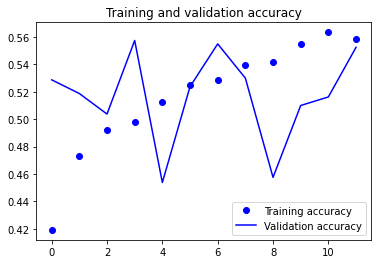

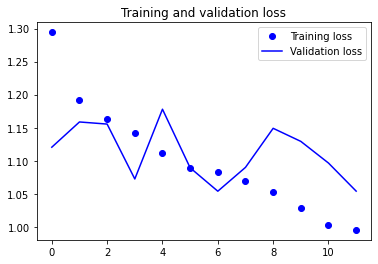

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_ex11.h5'))

28/28 [==============================] - 20s 478ms/step - loss: 1.0505 - accuracy: 0.5489
Test accuracy: 0.549
Test loss: 1.051
Classification report: 
              precision    recall  f1-score   support

           0     0.3810    0.1600    0.2254       150
           1     0.3663    0.7194    0.4854       139
           2     0.6274    0.5500    0.5861       300
           3     0.6862    0.6633    0.6746       300

    accuracy                         0.5489       889
   macro avg     0.5152    0.5232    0.4929       889
weighted avg     0.5648    0.5489    0.5394       889



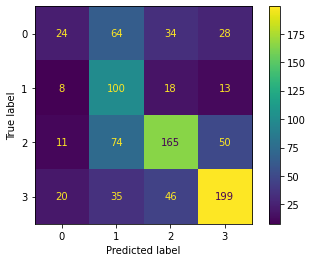

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

4678

### **Experiment 12] Data Augumentation + Global AVG Pooling + Dense 64 + Dropout 0.33**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.33)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
history = run_model(model, 'ResNet152_ex12', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2210 - accuracy: 0.4519
Epoch 00001: val_loss improved from inf to 1.11039, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex12.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 283s 768ms/step - loss: 1.2210 - accuracy: 0.4519 - val_loss: 1.1104 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1417 - accuracy: 0.5031
Epoch 00002: val_loss improved from 1.11039 to 1.09752, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex12.h5
225/225 [==============================] - 160s 710ms/step - loss: 1.1417 - accuracy: 0.5031 - val_loss: 1.0975 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.1116 - accuracy: 0.5189
Epoch 00003: val_loss improved from 1.09752 to 1.08436, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex12.h5
225/225 [==============================] - 160s 709ms/step - loss: 1.1116 - accuracy: 0.5189 - val_loss: 1.0844 - val_accuracy: 0.5362 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.533

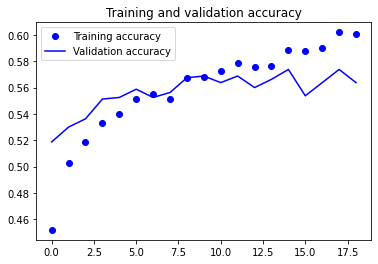

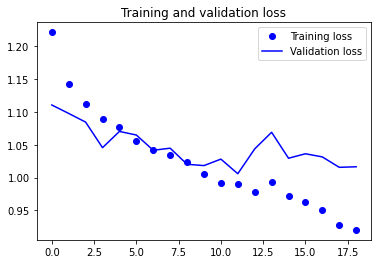

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_ex12.h5'))

28/28 [==============================] - 27s 691ms/step - loss: 0.9903 - accuracy: 0.5793
Test accuracy: 0.579
Test loss: 0.990
Classification report: 
              precision    recall  f1-score   support

           0     0.4444    0.1867    0.2629       150
           1     0.5000    0.4820    0.4908       139
           2     0.5667    0.6800    0.6182       300
           3     0.6506    0.7200    0.6835       300

    accuracy                         0.5793       889
   macro avg     0.5404    0.5172    0.5139       889
weighted avg     0.5639    0.5793    0.5604       889



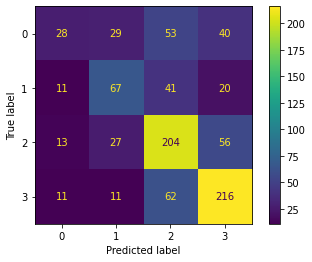

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

59387

### **Experiment 13] Data Augumentation + Global AVG Pooling + Dense 128 + Dropout 0.33**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.33)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272

In [ ]:
history = run_model(model, 'ResNet152_ex13', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2105 - accuracy: 0.4704
Epoch 00001: val_loss improved from inf to 1.10015, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex13.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 251s 633ms/step - loss: 1.2105 - accuracy: 0.4704 - val_loss: 1.1001 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.5253
Epoch 00002: val_loss improved from 1.10015 to 1.07606, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex13.h5
225/225 [==============================] - 132s 585ms/step - loss: 1.1124 - accuracy: 0.5253 - val_loss: 1.0761 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.0959 - accuracy: 0.5261
Epoch 00003: val_loss improved from 1.07606 to 1.06473, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_ex13.h5
225/225 [==============================] - 131s 584ms/step - loss: 1.0959 - accuracy: 0.5261 - val_loss: 1.0647 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.547

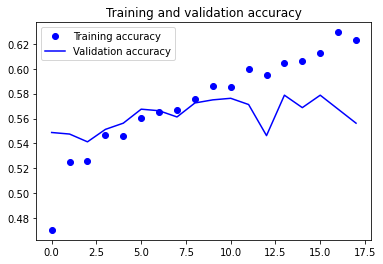

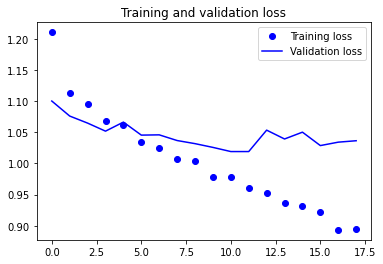

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_ex13.h5'))

28/28 [==============================] - 23s 563ms/step - loss: 1.0003 - accuracy: 0.5737
Test accuracy: 0.574
Test loss: 1.000
Classification report: 
              precision    recall  f1-score   support

           0     0.5417    0.0867    0.1494       150
           1     0.4965    0.5108    0.5035       139
           2     0.5520    0.6900    0.6133       300
           3     0.6311    0.7300    0.6770       300

    accuracy                         0.5737       889
   macro avg     0.5553    0.5044    0.4858       889
weighted avg     0.5683    0.5737    0.5394       889



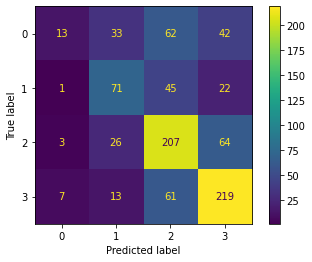

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

59361

## **Fine Tune ResNet152**

In [ ]:
conv_base.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [6]:
def get_model_to_fine_tune(model, num_of_layers=1, model_name='resnet152', verbose=False):
  if num_of_layers < 1:
      num_of_layers = 1

  res = tf.keras.models.load_model(os.path.join(MODELS_PATH, f'{model}.h5'))
  res.trainable = True

  conv_layers = [layer.name for layer in res.get_layer(model_name).layers if ('_conv' in layer.name or '_bn' in layer.name)]

  layer_names = conv_layers[-num_of_layers:]
  if verbose:
    print(layer_names)

  set_trainable = False
  for layer in res.get_layer(model_name).layers:
    if layer.name in layer_names:
      set_trainable = True
    else:
      set_trainable = False

    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  if verbose:
    for i, layer in enumerate(res.get_layer(model_name).layers):
      print(i, layer.name, layer.trainable)

  return res

In [ ]:
data_aug_model_1 = 'ResNet152_ex12'

In [ ]:
data_aug_model_2 = 'ResNet152_ex13'

In [ ]:
no_aug_model_1 = 'ResNet152_exp10'

### **Fine Tune 1] Unfreeze Last Block + Data Augumentation + Global AVG Pooling + Dense 64 + Dropout 0.33**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_1, num_of_layers=6, verbose=True)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_3_conv', 'conv5_block3_3_bn']
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_

In [ ]:
history = run_model(model, 'ResNet152_fine_tuned_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.5853
Epoch 00001: val_loss improved from inf to 1.02036, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 186s 775ms/step - loss: 0.9611 - accuracy: 0.5853 - val_loss: 1.0204 - val_accuracy: 0.5650 - lr: 1.0000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.6053
Epoch 00002: val_loss did not improve from 1.02036
225/225 [==============================] - 162s 719ms/step - loss: 0.9112 - accuracy: 0.6053 - val_loss: 1.0215 - val_accuracy: 0.5575 - lr: 1.0000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.6280
Epoch 00003: val_loss did not improve from 1.02036
225/225 [==============================] - 161s 717ms/step - loss: 0.8785 - accuracy: 0.6280 - val_loss: 1.0223 - val_accuracy: 0.5600 - lr: 1.0000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.8492 - accuracy: 0.6331
Epoch 00004: val_loss improved from 1.02036 to 1.01900, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp1.h5
225/225 

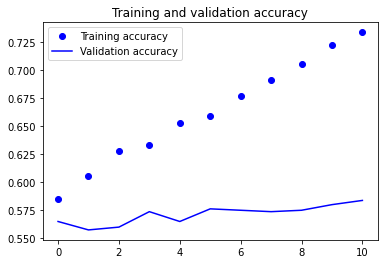

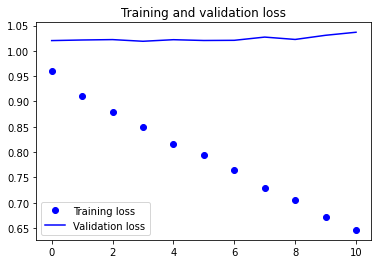

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_fine_tuned_exp1.h5'))

28/28 [==============================] - 21s 620ms/step - loss: 0.9744 - accuracy: 0.5894
Test accuracy: 0.589
Test loss: 0.974
Classification report: 
              precision    recall  f1-score   support

           0     0.4118    0.1400    0.2090       150
           1     0.5349    0.4964    0.5149       139
           2     0.5561    0.7100    0.6237       300
           3     0.6779    0.7367    0.7061       300

    accuracy                         0.5894       889
   macro avg     0.5452    0.5208    0.5134       889
weighted avg     0.5695    0.5894    0.5645       889



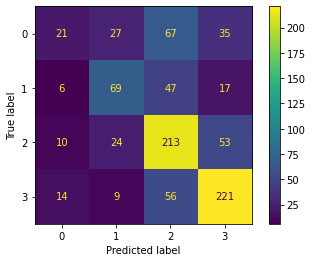

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 2] Unfreeze Last Block + Data Augumentation + Global AVG Pooling + Dense 128 + Dropout 0.33**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_2, num_of_conv_layers=6)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272

In [ ]:
history = run_model(model, 'ResNet152_fine_tuned_exp2', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.5864
Epoch 00001: val_loss improved from inf to 1.01766, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 151s 621ms/step - loss: 0.9672 - accuracy: 0.5864 - val_loss: 1.0177 - val_accuracy: 0.5800 - lr: 1.0000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9043 - accuracy: 0.6210
Epoch 00002: val_loss improved from 1.01766 to 1.01412, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp2.h5
225/225 [==============================] - 138s 613ms/step - loss: 0.9043 - accuracy: 0.6210 - val_loss: 1.0141 - val_accuracy: 0.5888 - lr: 1.0000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8686 - accuracy: 0.6398
Epoch 00003: val_loss improved from 1.01412 to 1.01265, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp2.h5
225/225 [==============================] - 137s 608ms/step - loss: 0.8686 - accuracy: 0.6398 - val_loss: 1.0127 - val_accuracy: 0.5987 - lr: 1.0000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0

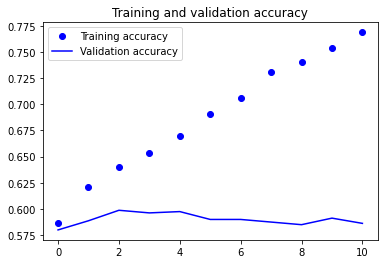

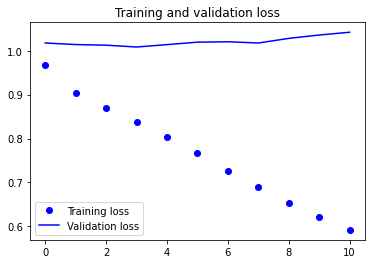

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_fine_tuned_exp2.h5'))

28/28 [==============================] - 21s 515ms/step - loss: 0.9715 - accuracy: 0.5861
Test accuracy: 0.586
Test loss: 0.972
Classification report: 
              precision    recall  f1-score   support

           0     0.3944    0.1867    0.2534       150
           1     0.5068    0.5396    0.5226       139
           2     0.5782    0.6900    0.6292       300
           3     0.6763    0.7033    0.6895       300

    accuracy                         0.5861       889
   macro avg     0.5389    0.5299    0.5237       889
weighted avg     0.5691    0.5861    0.5695       889



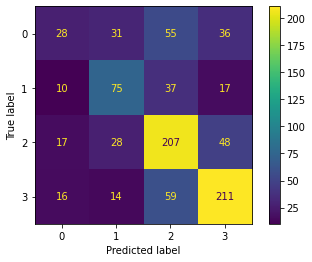

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Fine Tune 3] Unfreeze Last Block + Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
model = get_model_to_fine_tune(no_aug_model_1, num_of_layers=6)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_fine_tuned_exp3', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.5899
Epoch 00001: val_loss improved from inf to 1.01746, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp3.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 174s 317ms/step - loss: 0.9668 - accuracy: 0.5899 - val_loss: 1.0175 - val_accuracy: 0.5825 - lr: 1.0000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.8881 - accuracy: 0.6316
Epoch 00002: val_loss did not improve from 1.01746
225/225 [==============================] - 57s 251ms/step - loss: 0.8881 - accuracy: 0.6316 - val_loss: 1.0180 - val_accuracy: 0.5763 - lr: 1.0000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8530 - accuracy: 0.6501
Epoch 00003: val_loss improved from 1.01746 to 1.01651, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp3.h5
225/225 [==============================] - 60s 268ms/step - loss: 0.8530 - accuracy: 0.6501 - val_loss: 1.0165 - val_accuracy: 0.5725 - lr: 1.0000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.6672
Epoch 00004: val_loss improved from 1.01651 to 1.01434, savin

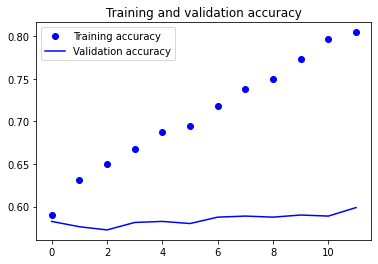

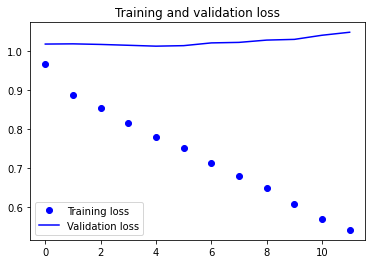

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_fine_tuned_exp3.h5'))

28/28 [==============================] - 17s 377ms/step - loss: 0.9733 - accuracy: 0.5894
Test accuracy: 0.589
Test loss: 0.973
Classification report: 
              precision    recall  f1-score   support

           0     0.3913    0.3000    0.3396       150
           1     0.5255    0.5180    0.5217       139
           2     0.6025    0.6467    0.6238       300
           3     0.6762    0.7100    0.6927       300

    accuracy                         0.5894       889
   macro avg     0.5489    0.5437    0.5445       889
weighted avg     0.5797    0.5894    0.5831       889



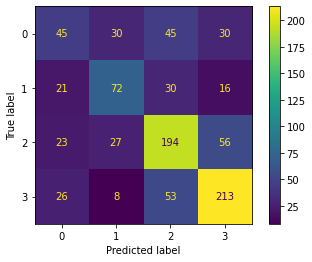

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 4] Unfreeze Last 4 Layers + Data Augumentation + Global AVG Pooling + Dense 128 + Dropout 0.33**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_2, num_of_conv_layers=4)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272

In [ ]:
history = run_model(model, 'ResNet152_fine_tuned_exp4', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.5892
Epoch 00001: val_loss improved from inf to 1.01619, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp4.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 156s 629ms/step - loss: 0.9543 - accuracy: 0.5892 - val_loss: 1.0162 - val_accuracy: 0.5725 - lr: 1.0000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9123 - accuracy: 0.6183
Epoch 00002: val_loss did not improve from 1.01619
225/225 [==============================] - 130s 578ms/step - loss: 0.9123 - accuracy: 0.6183 - val_loss: 1.0200 - val_accuracy: 0.5800 - lr: 1.0000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8834 - accuracy: 0.6323
Epoch 00003: val_loss did not improve from 1.01619
225/225 [==============================] - 130s 577ms/step - loss: 0.8834 - accuracy: 0.6323 - val_loss: 1.0209 - val_accuracy: 0.5775 - lr: 1.0000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.8571 - accuracy: 0.6440
Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.

Epoch 00004: val_loss did not improve from 1.01619
225/225 [=============

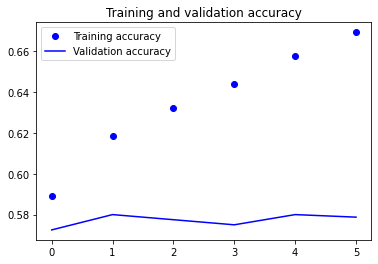

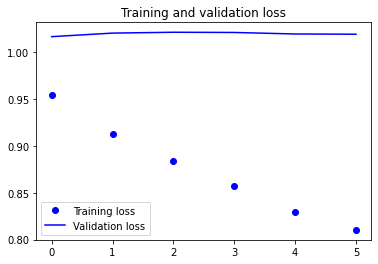

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_fine_tuned_exp4.h5'))

28/28 [==============================] - 18s 506ms/step - loss: 0.9808 - accuracy: 0.5883
Test accuracy: 0.588
Test loss: 0.981
Classification report: 
              precision    recall  f1-score   support

           0     0.4262    0.1733    0.2464       150
           1     0.5185    0.5036    0.5109       139
           2     0.5678    0.7400    0.6425       300
           3     0.6788    0.6833    0.6811       300

    accuracy                         0.5883       889
   macro avg     0.5478    0.5251    0.5203       889
weighted avg     0.5737    0.5883    0.5681       889



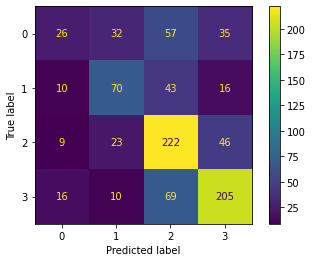

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 5] Unfreeze Last 4 Layers + Data Augumentation + Global AVG Pooling + Dense 64 + Dropout 0.33**

In [ ]:
model = get_model_to_fine_tune(no_aug_model_1, num_of_conv_layers=4)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_fine_tuned_exp5', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9504 - accuracy: 0.6005
Epoch 00001: val_loss improved from inf to 1.01514, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp5.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 189s 743ms/step - loss: 0.9504 - accuracy: 0.6005 - val_loss: 1.0151 - val_accuracy: 0.5875 - lr: 1.0000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.6234
Epoch 00002: val_loss improved from 1.01514 to 1.01433, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp5.h5
225/225 [==============================] - 164s 729ms/step - loss: 0.9012 - accuracy: 0.6234 - val_loss: 1.0143 - val_accuracy: 0.5700 - lr: 1.0000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8734 - accuracy: 0.6399
Epoch 00003: val_loss did not improve from 1.01433
225/225 [==============================] - 161s 714ms/step - loss: 0.8734 - accuracy: 0.6399 - val_loss: 1.0146 - val_accuracy: 0.5800 - lr: 1.0000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.6516
Epoch 00004: val_loss improved from 1.01433 to 1.01230, sav

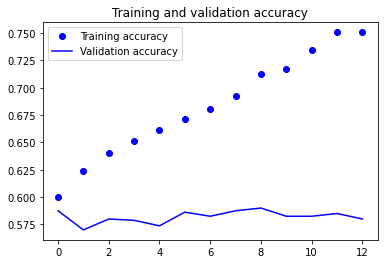

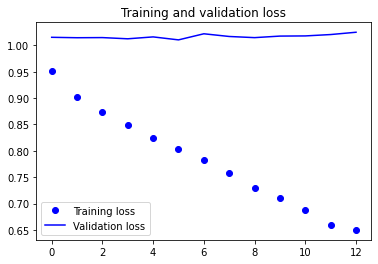

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_fine_tuned_exp5.h5'))

28/28 [==============================] - 21s 623ms/step - loss: 0.9756 - accuracy: 0.5861
Test accuracy: 0.586
Test loss: 0.976
Classification report: 
              precision    recall  f1-score   support

           0     0.4037    0.2933    0.3398       150
           1     0.5147    0.5036    0.5091       139
           2     0.5780    0.6667    0.6192       300
           3     0.6946    0.6900    0.6923       300

    accuracy                         0.5861       889
   macro avg     0.5478    0.5384    0.5401       889
weighted avg     0.5781    0.5861    0.5795       889



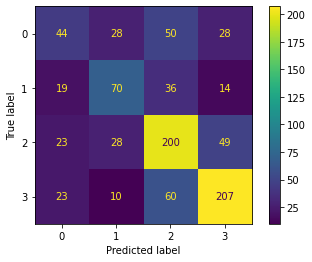

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 6] Unfreeze Last 8 Layers + Data Augumentation + Global AVG Pooling + Dense 128 + Dropout 0.33**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_2, num_of_conv_layers=8)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272

In [ ]:
history = run_model(model, 'ResNet152_fine_tuned_exp6', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.9745 - accuracy: 0.5862
Epoch 00001: val_loss improved from inf to 1.02332, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp6.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


225/225 [==============================] - 164s 638ms/step - loss: 0.9745 - accuracy: 0.5862 - val_loss: 1.0233 - val_accuracy: 0.5763 - lr: 1.0000e-05
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.9014 - accuracy: 0.6278
Epoch 00002: val_loss improved from 1.02332 to 1.01429, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp6.h5
225/225 [==============================] - 138s 614ms/step - loss: 0.9014 - accuracy: 0.6278 - val_loss: 1.0143 - val_accuracy: 0.5913 - lr: 1.0000e-05
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.8489 - accuracy: 0.6499
Epoch 00003: val_loss improved from 1.01429 to 1.01423, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_fine_tuned_exp6.h5
225/225 [==============================] - 138s 614ms/step - loss: 0.8489 - accuracy: 0.6499 - val_loss: 1.0142 - val_accuracy: 0.5788 - lr: 1.0000e-05
Epoch 4/20
225/225 [==============================] - ETA: 0

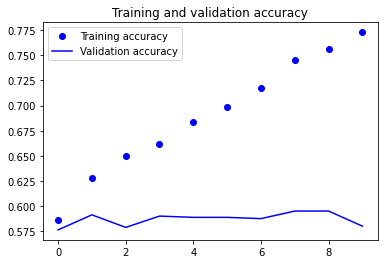

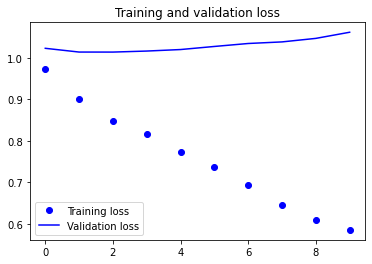

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_fine_tuned_exp6.h5'))

28/28 [==============================] - 18s 504ms/step - loss: 0.9765 - accuracy: 0.5849
Test accuracy: 0.585
Test loss: 0.977
Classification report: 
              precision    recall  f1-score   support

           0     0.3824    0.1733    0.2385       150
           1     0.5035    0.5180    0.5106       139
           2     0.5734    0.7033    0.6317       300
           3     0.6806    0.7033    0.6918       300

    accuracy                         0.5849       889
   macro avg     0.5350    0.5245    0.5182       889
weighted avg     0.5664    0.5849    0.5667       889



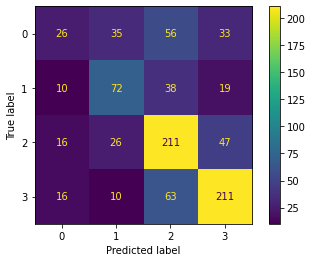

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **New Dataset**

In [10]:
!unzip /content/drive/MyDrive/CIDL_Group/ULTIMO_DATASET_VALE.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00007336_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00021327_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00022325_001.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00008899_009.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00028039_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00030460_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00022572_023.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00021145_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/

In [11]:
UPDATED_DATASET = '/content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET'
TRAIN_PATH = os.path.join(UPDATED_DATASET, 'train')
VAL_PATH = os.path.join(UPDATED_DATASET, 'val')
TEST_PATH = os.path.join(UPDATED_DATASET, 'test')

CLASSES = os.listdir(TRAIN_PATH)

100%|██████████| 4/4 [00:00<00:00, 105.87it/s]


Number of No Finding: 3240, proportion: 0.2907655030063717
Number of Atelectasis: 2384, proportion: 0.2139459750516019
Number of Effusion: 2279, proportion: 0.20452301893565467
Number of Infiltration: 3240, proportion: 0.2907655030063717


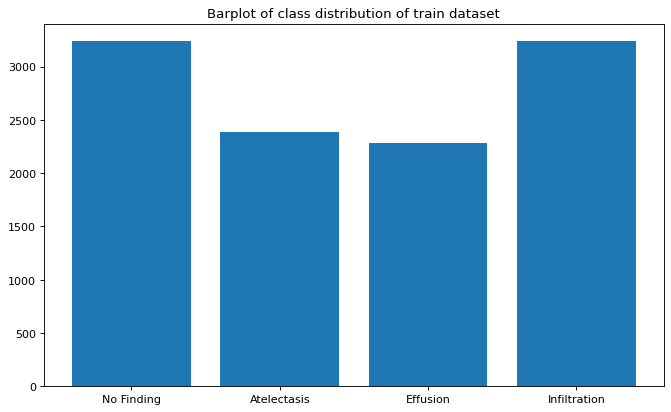

100%|██████████| 4/4 [00:00<00:00, 208.27it/s]


Number of No Finding: 360, proportion: 0.2786377708978328
Number of Atelectasis: 289, proportion: 0.2236842105263158
Number of Effusion: 283, proportion: 0.21904024767801858
Number of Infiltration: 360, proportion: 0.2786377708978328


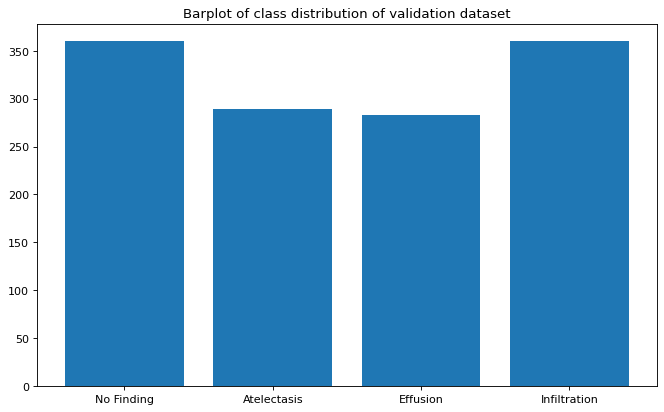

100%|██████████| 4/4 [00:00<00:00, 196.86it/s]


Number of No Finding: 400, proportion: 0.27816411682892905
Number of Atelectasis: 324, proportion: 0.22531293463143254
Number of Effusion: 314, proportion: 0.21835883171070933
Number of Infiltration: 400, proportion: 0.27816411682892905


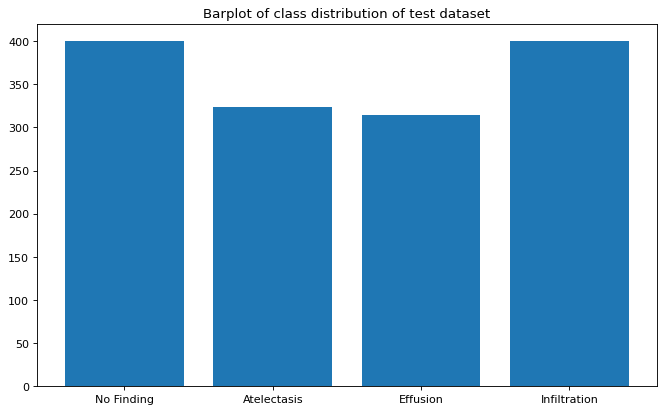

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

In [12]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
train_set_no_shuffle = load_training_set(IMAGE_SIZE, BATCH_SIZE, shuffle=False)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 11143 files belonging to 4 classes.
Found 11143 files belonging to 4 classes.
Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.


### **Experiment 1] Data Augumentation + Global AVG Pooling + Dense 64 + Dropout 0.33**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.33)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_updated_dataset_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 1.2400 - accuracy: 0.4267
Epoch 00001: val_loss improved from inf to 1.17029, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_exp1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


349/349 [==============================] - 263s 287ms/step - loss: 1.2400 - accuracy: 0.4267 - val_loss: 1.1703 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 1.1747 - accuracy: 0.4689
Epoch 00002: val_loss improved from 1.17029 to 1.10242, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_exp1.h5
349/349 [==============================] - 91s 261ms/step - loss: 1.1747 - accuracy: 0.4689 - val_loss: 1.1024 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 3/20
349/349 [==============================] - ETA: 0s - loss: 1.1438 - accuracy: 0.4922
Epoch 00003: val_loss did not improve from 1.10242
349/349 [==============================] - 89s 256ms/step - loss: 1.1438 - accuracy: 0.4922 - val_loss: 1.1086 - val_accuracy: 0.5379 - lr: 0.0010
Epoch 4/20
349/349 [==============================] - ETA: 0s - loss: 1.1291 - accuracy: 0.5052
Epoch 00004: val_loss did not improve from 1.10242
349/349 [========

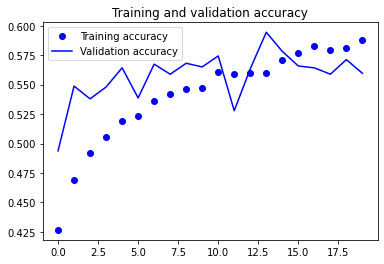

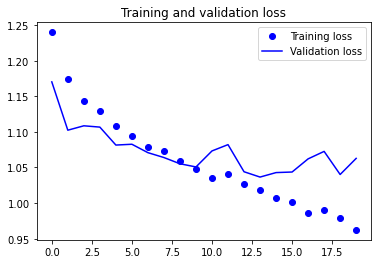

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_updated_dataset_exp1.h5'))

45/45 [==============================] - 25s 403ms/step - loss: 0.9971 - accuracy: 0.5981
Test accuracy: 0.598
Test loss: 0.997
Classification report: 
              precision    recall  f1-score   support

           0     0.5263    0.4321    0.4746       324
           1     0.5847    0.5828    0.5837       314
           2     0.5736    0.6525    0.6105       400
           3     0.6832    0.6900    0.6866       400

    accuracy                         0.5981      1438
   macro avg     0.5919    0.5894    0.5889      1438
weighted avg     0.5958    0.5981    0.5952      1438



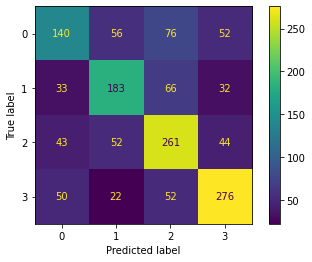

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 1 Fine Tune Last Block] Data Augumentation + Global AVG Pooling + Dense 64 + Dropout 0.33**

In [ ]:
updated_dataset_aug_model = 'ResNet152_updated_dataset_exp1'

In [ ]:
model = get_model_to_fine_tune(updated_dataset_aug_model, num_of_layers=6)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_updated_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 0.9948 - accuracy: 0.5787
Epoch 00001: val_loss improved from inf to 1.03984, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft_exp1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


349/349 [==============================] - 244s 295ms/step - loss: 0.9948 - accuracy: 0.5787 - val_loss: 1.0398 - val_accuracy: 0.5828 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.6031
Epoch 00002: val_loss improved from 1.03984 to 1.03170, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft_exp1.h5
349/349 [==============================] - 94s 268ms/step - loss: 0.9427 - accuracy: 0.6031 - val_loss: 1.0317 - val_accuracy: 0.5890 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.6237
Epoch 00003: val_loss improved from 1.03170 to 1.02894, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft_exp1.h5
349/349 [==============================] - 96s 276ms/step - loss: 0.9012 - accuracy: 0.6237 - val_loss: 1.0289 - val_accuracy: 0.5805 - lr: 1.0000e-05
Epoch 4/50
349/349 [==========================

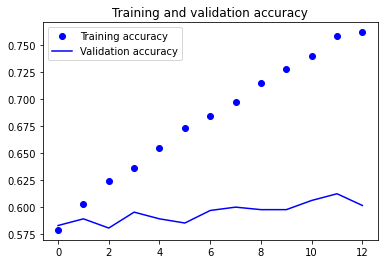

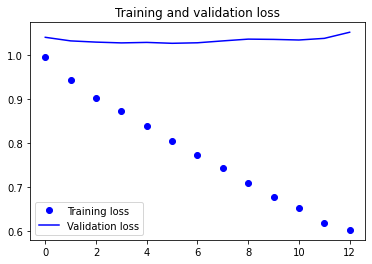

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_updated_dataset_ft_exp1.h5'))

45/45 [==============================] - 28s 495ms/step - loss: 0.9769 - accuracy: 0.6113
Test accuracy: 0.611
Test loss: 0.977
Classification report: 
              precision    recall  f1-score   support

           0     0.5691    0.4321    0.4912       324
           1     0.5938    0.6146    0.6041       314
           2     0.5791    0.6500    0.6125       400
           3     0.6842    0.7150    0.6993       400

    accuracy                         0.6113      1438
   macro avg     0.6066    0.6029    0.6018      1438
weighted avg     0.6093    0.6113    0.6075      1438



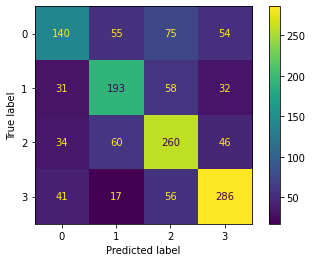

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 2] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_updated_dataset_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.4508
Epoch 00001: val_loss improved from inf to 1.13898, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_exp2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


349/349 [==============================] - 359s 578ms/step - loss: 1.2195 - accuracy: 0.4508 - val_loss: 1.1390 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.1382 - accuracy: 0.5035
Epoch 00002: val_loss improved from 1.13898 to 1.09949, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_exp2.h5
349/349 [==============================] - 194s 556ms/step - loss: 1.1382 - accuracy: 0.5035 - val_loss: 1.0995 - val_accuracy: 0.5341 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.1042 - accuracy: 0.5184
Epoch 00003: val_loss improved from 1.09949 to 1.07767, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_exp2.h5
349/349 [==============================] - 193s 553ms/step - loss: 1.1042 - accuracy: 0.5184 - val_loss: 1.0777 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 4/50
349/349 [==============================] - ETA: 0s 

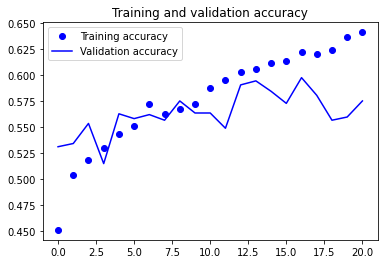

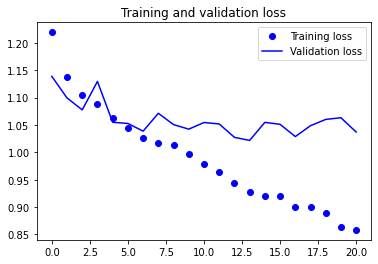

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_updated_dataset_exp2.h5'))

45/45 [==============================] - 31s 520ms/step - loss: 0.9857 - accuracy: 0.5876
Test accuracy: 0.588
Test loss: 0.986
Classification report: 
              precision    recall  f1-score   support

           0     0.5259    0.4383    0.4781       324
           1     0.5601    0.5637    0.5619       314
           2     0.5711    0.6125    0.5911       400
           3     0.6643    0.7025    0.6829       400

    accuracy                         0.5876      1438
   macro avg     0.5804    0.5792    0.5785      1438
weighted avg     0.5844    0.5876    0.5848      1438



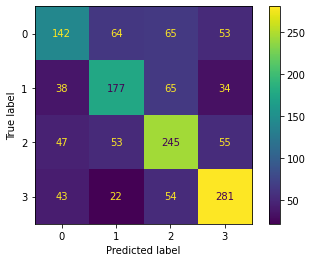

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 2 Fine Tune Last 2 Layers] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
updated_dataset_no_aug_model = 'ResNet152_updated_dataset_exp2'

In [ ]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=2)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_updated_dataset_ft_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.6314
Epoch 00001: val_loss improved from inf to 1.03119, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft_exp2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


349/349 [==============================] - 381s 625ms/step - loss: 0.8856 - accuracy: 0.6314 - val_loss: 1.0312 - val_accuracy: 0.5882 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.6359
Epoch 00002: val_loss improved from 1.03119 to 1.02925, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft_exp2.h5
349/349 [==============================] - 204s 585ms/step - loss: 0.8668 - accuracy: 0.6359 - val_loss: 1.0293 - val_accuracy: 0.5813 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.8533 - accuracy: 0.6474
Epoch 00003: val_loss improved from 1.02925 to 1.02561, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft_exp2.h5
349/349 [==============================] - 204s 585ms/step - loss: 0.8533 - accuracy: 0.6474 - val_loss: 1.0256 - val_accuracy: 0.5813 - lr: 1.0000e-05
Epoch 4/50
349/349 [========================

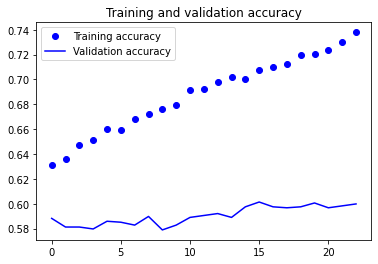

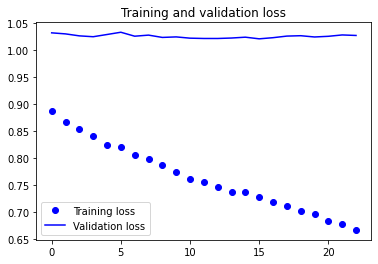

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_updated_dataset_ft_exp2.h5'))

45/45 [==============================] - 38s 494ms/step - loss: 0.9819 - accuracy: 0.5987
Test accuracy: 0.599
Test loss: 0.982
Classification report: 
              precision    recall  f1-score   support

           0     0.5489    0.4506    0.4949       324
           1     0.5719    0.5828    0.5773       314
           2     0.5789    0.6325    0.6045       400
           3     0.6723    0.6975    0.6847       400

    accuracy                         0.5987      1438
   macro avg     0.5930    0.5909    0.5904      1438
weighted avg     0.5966    0.5987    0.5962      1438



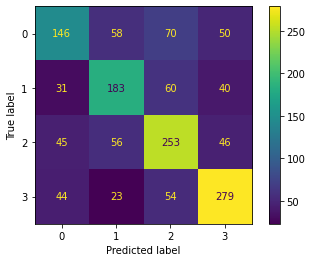

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 2 Fine Tune Last 2 Layers 50 Layers] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=50, verbose=True)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

['conv4_block32_1_conv', 'conv4_block32_1_bn', 'conv4_block32_2_conv', 'conv4_block32_2_bn', 'conv4_block32_3_conv', 'conv4_block32_3_bn', 'conv4_block33_1_conv', 'conv4_block33_1_bn', 'conv4_block33_2_conv', 'conv4_block33_2_bn', 'conv4_block33_3_conv', 'conv4_block33_3_bn', 'conv4_block34_1_conv', 'conv4_block34_1_bn', 'conv4_block34_2_conv', 'conv4_block34_2_bn', 'conv4_block34_3_conv', 'conv4_block34_3_bn', 'conv4_block35_1_conv', 'conv4_block35_1_bn', 'conv4_block35_2_conv', 'conv4_block35_2_bn', 'conv4_block35_3_conv', 'conv4_block35_3_bn', 'conv4_block36_1_conv', 'conv4_block36_1_bn', 'conv4_block36_2_conv', 'conv4_block36_2_bn', 'conv4_block36_3_conv', 'conv4_block36_3_bn', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_3_conv', 'conv5_block2_3_bn', '

In [ ]:
history = run_model(model, 'ResNet152_updated_dataset_ft2_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.0613 - accuracy: 0.5522
Epoch 00001: val_loss improved from inf to 1.04705, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft2_exp2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


349/349 [==============================] - 276s 743ms/step - loss: 1.0613 - accuracy: 0.5522 - val_loss: 1.0471 - val_accuracy: 0.5666 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.6670
Epoch 00002: val_loss improved from 1.04705 to 1.03535, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft2_exp2.h5
349/349 [==============================] - 255s 730ms/step - loss: 0.7917 - accuracy: 0.6670 - val_loss: 1.0353 - val_accuracy: 0.5882 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.7450
Epoch 00003: val_loss did not improve from 1.03535
349/349 [==============================] - 249s 713ms/step - loss: 0.6072 - accuracy: 0.7450 - val_loss: 1.0541 - val_accuracy: 0.6060 - lr: 1.0000e-05
Epoch 4/50
349/349 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8168
Epoch 00004: val_loss did not improve from 1.03535

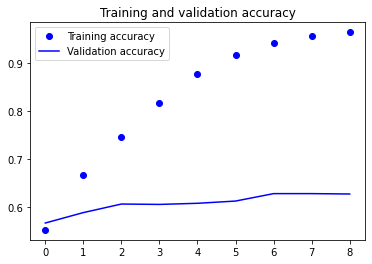

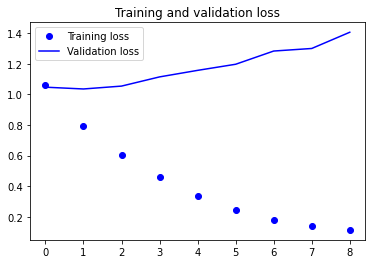

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_updated_dataset_ft2_exp2.h5'))

45/45 [==============================] - 31s 520ms/step - loss: 1.0047 - accuracy: 0.6022
Test accuracy: 0.602
Test loss: 1.005
Classification report: 
              precision    recall  f1-score   support

           0     0.5817    0.3735    0.4549       324
           1     0.5642    0.6720    0.6134       314
           2     0.5800    0.6250    0.6017       400
           3     0.6682    0.7100    0.6885       400

    accuracy                         0.6022      1438
   macro avg     0.5985    0.5951    0.5896      1438
weighted avg     0.6015    0.6022    0.5953      1438



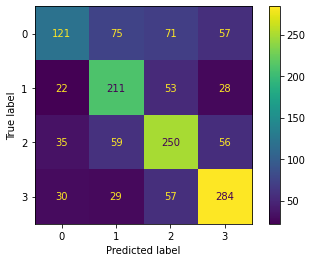

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 2 Fine Tune Last 2 Layers 150 Layers] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=150)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136

In [ ]:
history = run_model(model, 'ResNet152_updated_dataset_ft3_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.1155 - accuracy: 0.5151
Epoch 1: val_loss improved from inf to 1.04171, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft3_exp2.h5
349/349 [==============================] - 492s 1s/step - loss: 1.1155 - accuracy: 0.5151 - val_loss: 1.0417 - val_accuracy: 0.5766 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.6682
Epoch 2: val_loss improved from 1.04171 to 1.02308, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_updated_dataset_ft3_exp2.h5
349/349 [==============================] - 469s 1s/step - loss: 0.7638 - accuracy: 0.6682 - val_loss: 1.0231 - val_accuracy: 0.5983 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.7790
Epoch 3: val_loss did not improve from 1.02308
349/349 [==============================] - 461s 1s/step - loss: 0.526

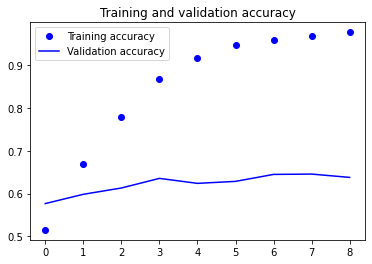

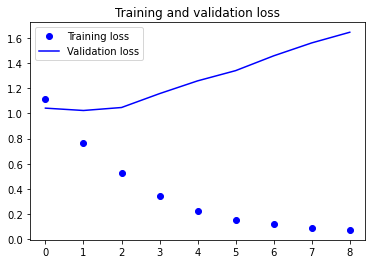

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_updated_dataset_ft3_exp2.h5'))

45/45 [==============================] - 48s 767ms/step - loss: 0.9834 - accuracy: 0.6134
Test accuracy: 0.613
Test loss: 0.983
Classification report: 
              precision    recall  f1-score   support

           0     0.5390    0.4691    0.5017       324
           1     0.6048    0.6433    0.6235       314
           2     0.6243    0.5900    0.6067       400
           3     0.6577    0.7300    0.6919       400

    accuracy                         0.6134      1438
   macro avg     0.6064    0.6081    0.6059      1438
weighted avg     0.6101    0.6134    0.6104      1438



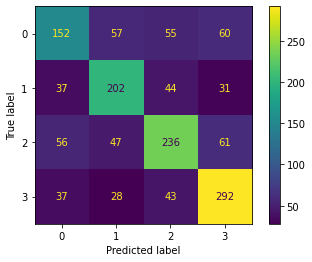

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **ResNet50**

### **Experiment 1] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [15]:
conv_base50 = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,)
)
conv_base50.summary()
conv_base50.trainable = False

inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = conv_base50(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
history = run_model(model, 'ResNet50_updated_dataset_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.2381 - accuracy: 0.4372
Epoch 1: val_loss improved from inf to 1.17272, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet50_updated_dataset_exp1.h5
349/349 [==============================] - 245s 281ms/step - loss: 1.2381 - accuracy: 0.4372 - val_loss: 1.1727 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.1370 - accuracy: 0.4979
Epoch 2: val_loss improved from 1.17272 to 1.10433, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet50_updated_dataset_exp1.h5
349/349 [==============================] - 86s 246ms/step - loss: 1.1370 - accuracy: 0.4979 - val_loss: 1.1043 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.5191
Epoch 3: val_loss improved from 1.10433 to 1.07890, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet50_updated

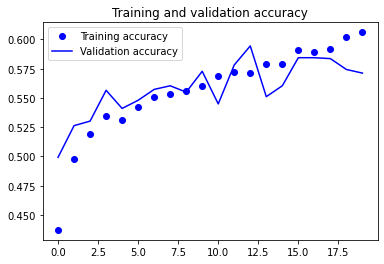

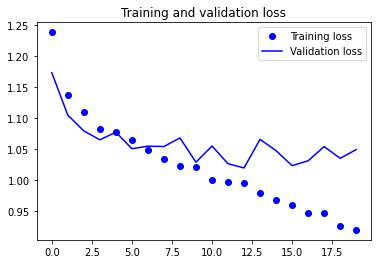

In [17]:
show_training_and_validation_performance(history)

In [18]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet50_updated_dataset_exp1.h5'))

45/45 [==============================] - 22s 398ms/step - loss: 0.9919 - accuracy: 0.5981
Test accuracy: 0.598
Test loss: 0.992
Classification report: 
              precision    recall  f1-score   support

           0     0.5255    0.4444    0.4816       324
           1     0.5796    0.5796    0.5796       314
           2     0.6059    0.6150    0.6104       400
           3     0.6486    0.7200    0.6825       400

    accuracy                         0.5981      1438
   macro avg     0.5899    0.5898    0.5885      1438
weighted avg     0.5940    0.5981    0.5947      1438



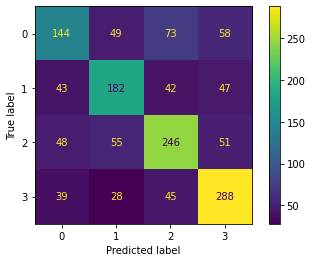

In [19]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [20]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 1 Fine Tune Last 2 Layers] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [25]:
updated_dataset_no_aug_model = 'ResNet50_updated_dataset_exp1'

In [29]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=2, model_name='resnet50')
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [28]:
history = run_model(model, 'ResNet50_updated_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.5903
Epoch 1: val_loss improved from inf to 1.01985, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet50_updated_dataset_ft_exp1.h5
349/349 [==============================] - 97s 253ms/step - loss: 0.9558 - accuracy: 0.5903 - val_loss: 1.0199 - val_accuracy: 0.5766 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.9293 - accuracy: 0.6011
Epoch 2: val_loss improved from 1.01985 to 1.01824, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet50_updated_dataset_ft_exp1.h5
349/349 [==============================] - 87s 249ms/step - loss: 0.9293 - accuracy: 0.6011 - val_loss: 1.0182 - val_accuracy: 0.5882 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.9212 - accuracy: 0.6021
Epoch 3: val_loss improved from 1.01824 to 1.01646, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/Res

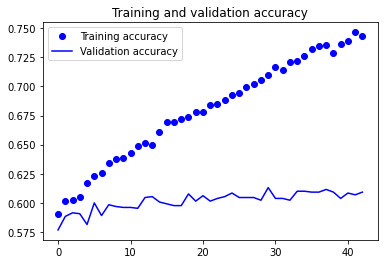

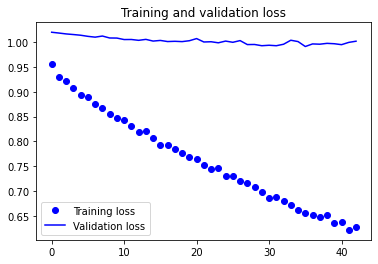

In [30]:
show_training_and_validation_performance(history)

In [31]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet50_updated_dataset_ft_exp1.h5'))

45/45 [==============================] - 11s 210ms/step - loss: 0.9587 - accuracy: 0.6134
Test accuracy: 0.613
Test loss: 0.959
Classification report: 
              precision    recall  f1-score   support

           0     0.5551    0.4660    0.5067       324
           1     0.6119    0.6529    0.6317       314
           2     0.5826    0.6525    0.6156       400
           3     0.6919    0.6625    0.6769       400

    accuracy                         0.6134      1438
   macro avg     0.6104    0.6085    0.6077      1438
weighted avg     0.6132    0.6134    0.6116      1438



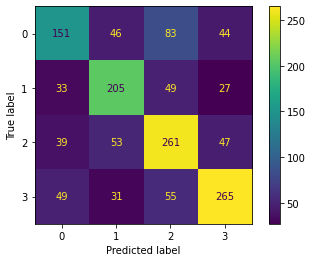

In [32]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [33]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **Preprocessed Dataset**

In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED.zip -d /content

In [8]:
UPDATED_DATASET = '/content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED'
TRAIN_PATH = os.path.join(UPDATED_DATASET, 'train')
VAL_PATH = os.path.join(UPDATED_DATASET, 'val')
TEST_PATH = os.path.join(UPDATED_DATASET, 'test')

CLASSES = os.listdir(TRAIN_PATH)

100%|██████████| 4/4 [00:00<00:00, 142.93it/s]

Number of Effusion: 2279, proportion: 0.20452301893565467
Number of Infiltration: 3240, proportion: 0.2907655030063717
Number of No Finding: 3240, proportion: 0.2907655030063717
Number of Atelectasis: 2384, proportion: 0.2139459750516019


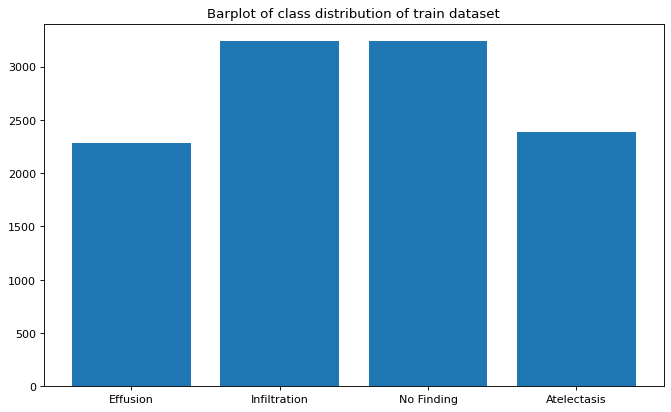

100%|██████████| 4/4 [00:00<00:00, 639.25it/s]


Number of Effusion: 283, proportion: 0.21904024767801858
Number of Infiltration: 360, proportion: 0.2786377708978328
Number of No Finding: 360, proportion: 0.2786377708978328
Number of Atelectasis: 289, proportion: 0.2236842105263158


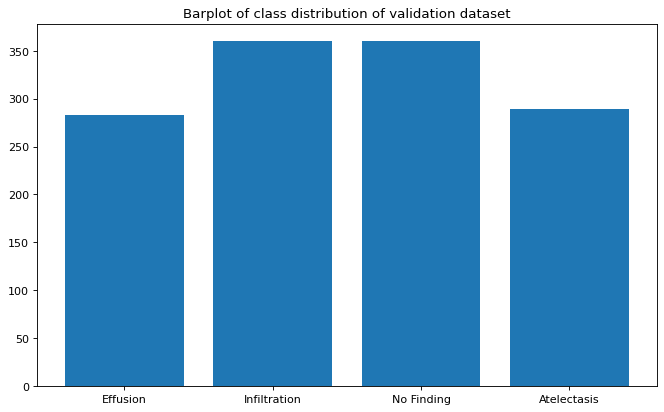

100%|██████████| 4/4 [00:00<00:00, 625.81it/s]


Number of Effusion: 314, proportion: 0.21835883171070933
Number of Infiltration: 400, proportion: 0.27816411682892905
Number of No Finding: 400, proportion: 0.27816411682892905
Number of Atelectasis: 324, proportion: 0.22531293463143254


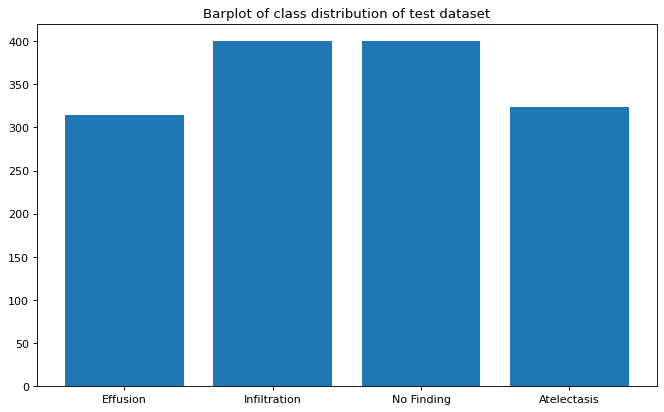

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

In [9]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 8766 files belonging to 3 classes.


FileNotFoundError: ignored

### **Experiment 1] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                             

In [ ]:
history = run_model(model, 'ResNet152_preprocessed_dataset_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.2969 - accuracy: 0.3812
Epoch 1: val_loss improved from inf to 1.20504, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_preprocessed_dataset_exp1.h5
349/349 [==============================] - 220s 301ms/step - loss: 1.2969 - accuracy: 0.3812 - val_loss: 1.2050 - val_accuracy: 0.4551 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.2119 - accuracy: 0.4365
Epoch 2: val_loss improved from 1.20504 to 1.16506, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_preprocessed_dataset_exp1.h5
349/349 [==============================] - 100s 285ms/step - loss: 1.2119 - accuracy: 0.4365 - val_loss: 1.1651 - val_accuracy: 0.4822 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.1748 - accuracy: 0.4590
Epoch 3: val_loss improved from 1.16506 to 1.13371, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/Res

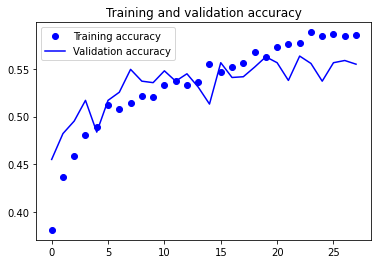

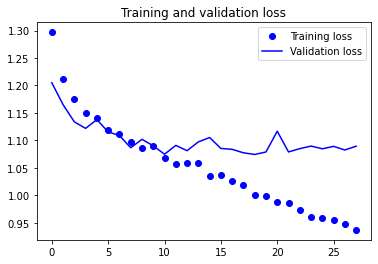

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_preprocessed_dataset_exp1.h5'))

45/45 [==============================] - 21s 329ms/step - loss: 1.0556 - accuracy: 0.5501
Test accuracy: 0.550
Test loss: 1.056
Classification report: 
              precision    recall  f1-score   support

           0     0.4226    0.4043    0.4132       324
           1     0.5863    0.4650    0.5187       314
           2     0.5239    0.6300    0.5721       400
           3     0.6583    0.6550    0.6566       400

    accuracy                         0.5501      1438
   macro avg     0.5478    0.5386    0.5402      1438
weighted avg     0.5521    0.5501    0.5481      1438



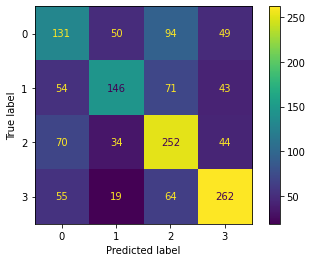

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Experiment 1 Fine Tune Last 2 Layers] Global AVG Pooling + Dense 64 + Dropout 0.25**

In [ ]:
updated_dataset_no_aug_model = 'ResNet152_preprocessed_dataset_exp1'

In [ ]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=2)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                             

In [ ]:
history = run_model(model, 'ResNet152_preprocessed_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 0.9675 - accuracy: 0.5849
Epoch 1: val_loss improved from inf to 1.07070, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_preprocessed_dataset_ft_exp1.h5
349/349 [==============================] - 110s 286ms/step - loss: 0.9675 - accuracy: 0.5849 - val_loss: 1.0707 - val_accuracy: 0.5457 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.5917
Epoch 2: val_loss improved from 1.07070 to 1.06913, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/ResNet152_preprocessed_dataset_ft_exp1.h5
349/349 [==============================] - 96s 276ms/step - loss: 0.9527 - accuracy: 0.5917 - val_loss: 1.0691 - val_accuracy: 0.5441 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.9418 - accuracy: 0.5981
Epoch 3: val_loss improved from 1.06913 to 1.06668, saving model to /content/drive/MyDrive/CIDL_Group/t

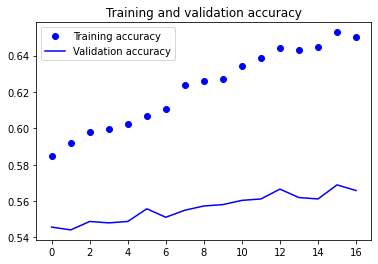

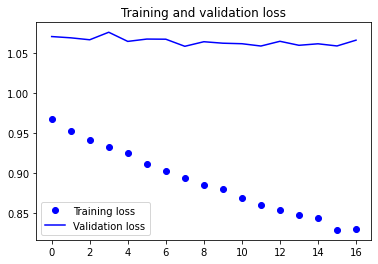

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'ResNet152_preprocessed_dataset_ft_exp1.h5'))

45/45 [==============================] - 14s 234ms/step - loss: 1.0495 - accuracy: 0.5438
Test accuracy: 0.544
Test loss: 1.050
Classification report: 
              precision    recall  f1-score   support

           0     0.4074    0.3395    0.3704       324
           1     0.5585    0.4713    0.5112       314
           2     0.5173    0.6350    0.5701       400
           3     0.6553    0.6750    0.6650       400

    accuracy                         0.5438      1438
   macro avg     0.5346    0.5302    0.5292      1438
weighted avg     0.5399    0.5438    0.5387      1438



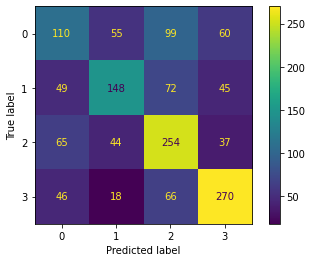

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()